In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import *
from sklearn.linear_model import LinearRegression
import pystan
import pickle
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error

In [2]:
u='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/'
c1 = "Date,Country_Region,Last_Update,Lat,Long_,Confirmed,"
c2 = "Deaths,Recovered,Active,FIPS,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,UID,ISO3,"
c3 = "Testing_Rate,Hospitalization_Rate"
labels = c1+c2+c3
cols = labels.split(',')
print cols

['Date', 'Country_Region', 'Last_Update', 'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'FIPS', 'Incident_Rate', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'UID', 'ISO3', 'Testing_Rate', 'Hospitalization_Rate']


In [3]:
df_ox = pd.read_csv('https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv')
df_ox = df_ox.loc[df_ox['CountryName'] == "United States"]
df_ox = df_ox.loc[df_ox['Date'].isin(range(20200123, 20200803))]
df_ox = df_ox.drop(["CountryName", "CountryCode", "C1_Flag", "C2_Flag", "C3_Flag", "C4_Flag", "C5_Flag", "C6_Flag", "C7_Flag",
                    "E1_Flag", "H1_Flag", "M1_Wildcard", "Date"], axis=1)
df_ox = df_ox.dropna()
df_ox.reset_index(drop=True, inplace=True)
df_ox.columns

Index([u'C1_School closing', u'C2_Workplace closing',
       u'C3_Cancel public events', u'C4_Restrictions on gatherings',
       u'C5_Close public transport', u'C6_Stay at home requirements',
       u'C7_Restrictions on internal movement',
       u'C8_International travel controls', u'E1_Income support',
       u'E2_Debt/contract relief', u'E3_Fiscal measures',
       u'E4_International support', u'H1_Public information campaigns',
       u'H2_Testing policy', u'H3_Contact tracing',
       u'H4_Emergency investment in healthcare', u'H5_Investment in vaccines',
       u'ConfirmedCases', u'ConfirmedDeaths', u'StringencyIndex',
       u'StringencyIndexForDisplay', u'StringencyLegacyIndex',
       u'StringencyLegacyIndexForDisplay', u'GovernmentResponseIndex',
       u'GovernmentResponseIndexForDisplay', u'ContainmentHealthIndex',
       u'ContainmentHealthIndexForDisplay', u'EconomicSupportIndex',
       u'EconomicSupportIndexForDisplay'],
      dtype='object')

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')
df = df.iloc[:, 12:205]
df = df.sum(axis =0)
df = df.drop("7/27/20")
df.reset_index(drop=True, inplace=True)

In [5]:
lst = [1]
for i in range(1, len(df)):
    lst.append(df[i]-df[i-1])


In [6]:
lstdf = pd.DataFrame(lst, columns = ['Daily'])
df = df.to_frame(name="Confirmed")
df = df.join(lstdf)

In [7]:
df_hos = pd.read_csv("https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/Hospitalization_all_locs.csv")
df_hos = df_hos.iloc[:, 43:-22]
df_hos = df_hos.sum(axis=0)

In [8]:
df_deaths = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")
df_deaths = df_deaths.iloc[:, 13:-11]
df_deaths = df_deaths.sum(axis=0)
df_deaths

1/23/20         0
1/24/20         0
1/25/20         0
1/26/20         0
1/27/20         0
1/28/20         0
1/29/20         0
1/30/20         0
1/31/20         0
2/1/20          0
2/2/20          0
2/3/20          0
2/4/20          0
2/5/20          0
2/6/20          0
2/7/20          0
2/8/20          0
2/9/20          0
2/10/20         0
2/11/20         0
2/12/20         0
2/13/20         0
2/14/20         0
2/15/20         0
2/16/20         0
2/17/20         0
2/18/20         0
2/19/20         0
2/20/20         0
2/21/20         0
            ...  
7/8/20     132744
7/9/20     133756
7/10/20    134586
7/11/20    135277
7/12/20    135728
7/13/20    136117
7/14/20    137045
7/15/20    138013
7/16/20    138966
7/17/20    139886
7/18/20    140756
7/19/20    141201
7/20/20    141715
7/21/20    142824
7/22/20    144035
7/23/20    145156
7/24/20    146279
7/25/20    147180
7/26/20    147657
7/27/20    148782
7/28/20    150150
7/29/20    151586
7/30/20    152802
7/31/20    154048
8/1/20    

In [9]:
df_rec = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
is_US =  (df_rec['Country/Region']=='US')
df_rec = df_rec[is_US]
df_rec = df_rec.drop(["Country/Region", "Province/State", "Lat", "Long", "1/22/20"], axis =1)
df_rec = df_rec.transpose()

In [10]:
df.reset_index(drop=True, inplace=True)
df_hos.reset_index(drop=True, inplace=True)
df_deaths.reset_index (drop=True, inplace=True)
df_rec.reset_index(drop=True, inplace=True)
df_full = pd.concat([df, df_hos, df_deaths, df_rec, df_ox], axis =1)
df_full.columns = ['Confirmed', 'Daily', 'Hospitalizations', 'Deaths', 'Recovered', 'C1_School closing', 'C2_Workplace closing',
       'C3_Cancel public events', 'C4_Restrictions on gatherings',
       'C5_Close public transport', 'C6_Stay at home requirements',
       'C7_Restrictions on internal movement',
       'C8_International travel controls', 'E1_Income support',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'ConfirmedCases', u'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDisplay', 'GovernmentResponseIndex',
       'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex',
       'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex',
       'EconomicSupportIndexForDisplay']

df_full = df_full.dropna()


In [11]:
df_full

,Confirmed,Daily,Hospitalizations,Deaths,Recovered,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,...,StringencyIndex,StringencyIndexForDisplay,StringencyLegacyIndex,StringencyLegacyIndexForDisplay,GovernmentResponseIndex,GovernmentResponseIndexForDisplay,ContainmentHealthIndex,ContainmentHealthIndexForDisplay,EconomicSupportIndex,EconomicSupportIndexForDisplay
0,1.0,1.0,77.814000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
1,2.0,1.0,77.814000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
2,2.0,0.0,77.814000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
3,5.0,3.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
4,5.0,0.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
5,5.0,0.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
6,5.0,0.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
7,5.0,0.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
8,7.0,2.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0
9,8.0,1.0,14.493000,0.0,0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.00,0.00,0.00,3.85,3.85,4.55,4.55,0.0,0.0


In [12]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [13]:
start_date = datetime.date(2020, 1, 23)
end_date = datetime.date(2020, 8, 2)
delta = datetime.timedelta(days=1)
date = start_date
dates_list = []
while(date <= end_date):
    if(date.month/10 ==0):
        mo = '0' + str(date.month)
    else:
        mo = str(date.month)
    if(date.day /10 ==0):
        day = '0'+ str(date.day)
    else:
        day = str(date.day)
    dates_list.append("2020-"+ mo + "-" + day)
    date+=delta
    
print dates_list[192-11:]

['2020-07-22', '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26', '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30', '2020-07-31', '2020-08-01', '2020-08-02']


In [14]:
training_set = df_full.head(191-21).iloc[:, 0:1]
testing_set = df_full.tail(21).iloc[:, 0:1]
print len(training_set)
print len(testing_set)

170
21


In [36]:
def train_test(date):
    training_set = df_full.head(191-date).iloc[:, 1:2]
    testing_set = df_full.tail(date).iloc[:, 1:2]
    full_set = df_full.iloc[:, 1:2].values
    df_train = df_full.head(191-date)
    df_test = df_full.tail(date)
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)
    print training_set_scaled.shape
    X_train = []
    y_train = []
    for i in range(20, 191-date):
        X_train.append(training_set_scaled[i-20:i, 0])
        y_train.append(training_set_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    print X_train.shape
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    regressor = Sequential()

    regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50, return_sequences = True))
    regressor.add(Dropout(0.2))

    regressor.add(LSTM(units = 50))
    regressor.add(Dropout(0.2))

    regressor.add(Dense(units = 1))

    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

    regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
    dataset_total = pd.concat((df_train['Daily'], df_test['Daily']), axis = 0)
    inputs = dataset_total[len(dataset_total) - len(df_test) - 20:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    print inputs.shape
    X_test = []
    for i in range(20, inputs.shape[0]):
        X_test.append(inputs[i-20:i, 0])
    X_test = np.array(X_test)
    print X_test.shape
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_confirmed = regressor.predict(X_test)
    predicted_confirmed = sc.inverse_transform(predicted_confirmed)
    print predicted_confirmed.shape
    
    output_df1 = pd.DataFrame(columns = ['location', 'target', 'target_end_date', 'forecast_date', 'point', 'quantile'])
    output_df1['location'] = ['US']*date
    output_df1['target'] = ['Daily Cases']*date
    output_df1['target_end_date'] = dates_list[(192-date+1):]
    output_df1['forecast_date'] = [dates_list[-(date+1)]]*date
    output_df1['point'] = predicted_confirmed
    output_df1['quantile'] = ['NA']*date
    output_df1.to_csv("day" + str(dates_list[-(date+1)]) +"-GITIDEAS-LSTM_daily_2.csv", index=False)    
    return full_set, predicted_confirmed

In [37]:
for i in range(21, 22):
    y, y_hat =train_test(i)

(170, 1)
(150, 20)
Epoch 1/100
150/150 [==============================] - 3s 18ms/step - loss: 0.1146
Epoch 2/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0393
Epoch 3/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0280
Epoch 4/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0258
Epoch 5/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 6/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0221
Epoch 7/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0181
Epoch 8/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0166
Epoch 9/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0158
Epoch 10/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0153
Epoch 11/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0152
Epoch 12/100
150/150 [==============================] - 0s 1ms/step - loss: 

150/150 [==============================] - 0s 1ms/step - loss: 0.0041
Epoch 100/100
150/150 [==============================] - 0s 1ms/step - loss: 0.0049
(41, 1)
(21, 20)
(21, 1)


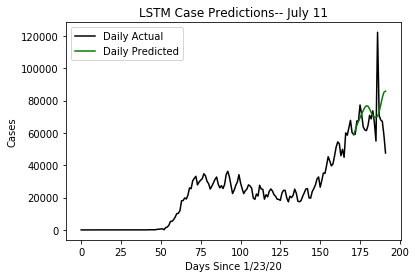

In [38]:
plt.plot(range(0, 192), y, color = 'black', label = 'Daily Actual')
plt.plot(range(171, 192), y_hat, color = 'green', label = 'Daily Predicted')
plt.title('LSTM Case Predictions-- July 11')
plt.xlabel('Days Since 1/23/20')
plt.ylabel('Cases')
plt.legend()
plt.show()

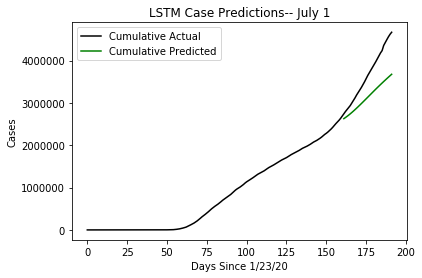

In [31]:
plt.plot(range(0, 192), y, color = 'black', label = 'Cumulative Actual')
plt.plot(range(161, 192), y_hat, color = 'green', label = 'Cumulative Predicted')
plt.title('LSTM Case Predictions-- July 1')
plt.xlabel('Days Since 1/23/20')
plt.ylabel('Cases')
plt.legend()
plt.show()

In [40]:
print mean_squared_error(y[171:192], y_hat)

296985530.0689254
